In [21]:
! pip install import-ipynb

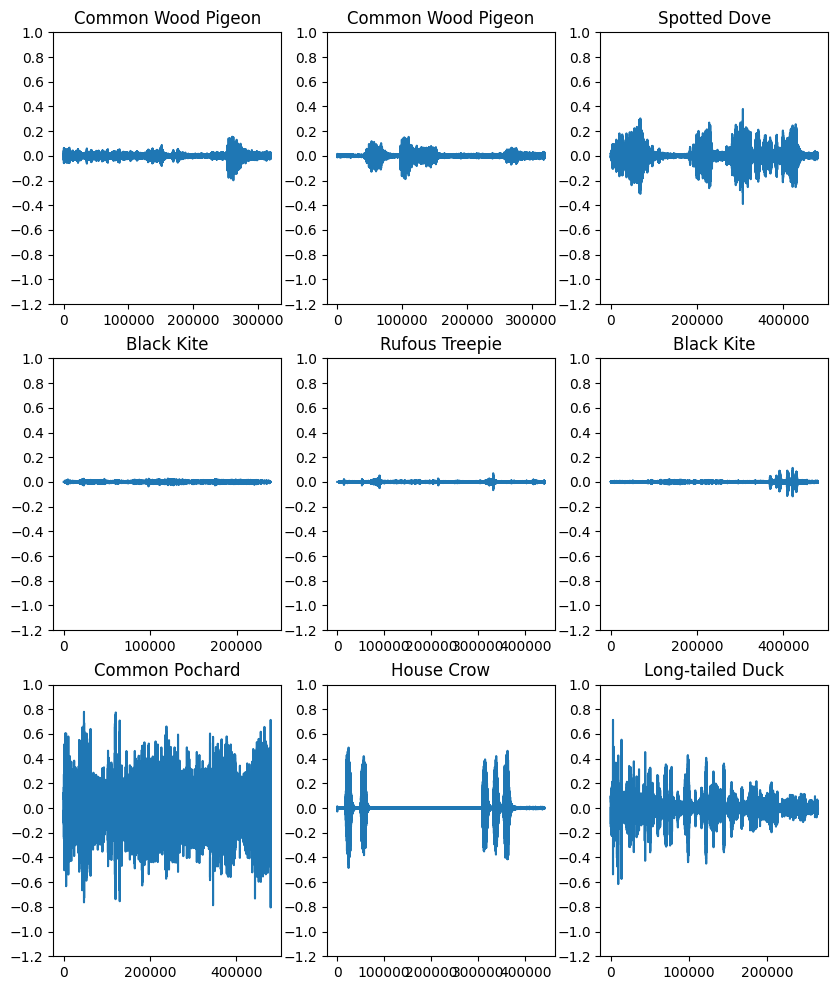

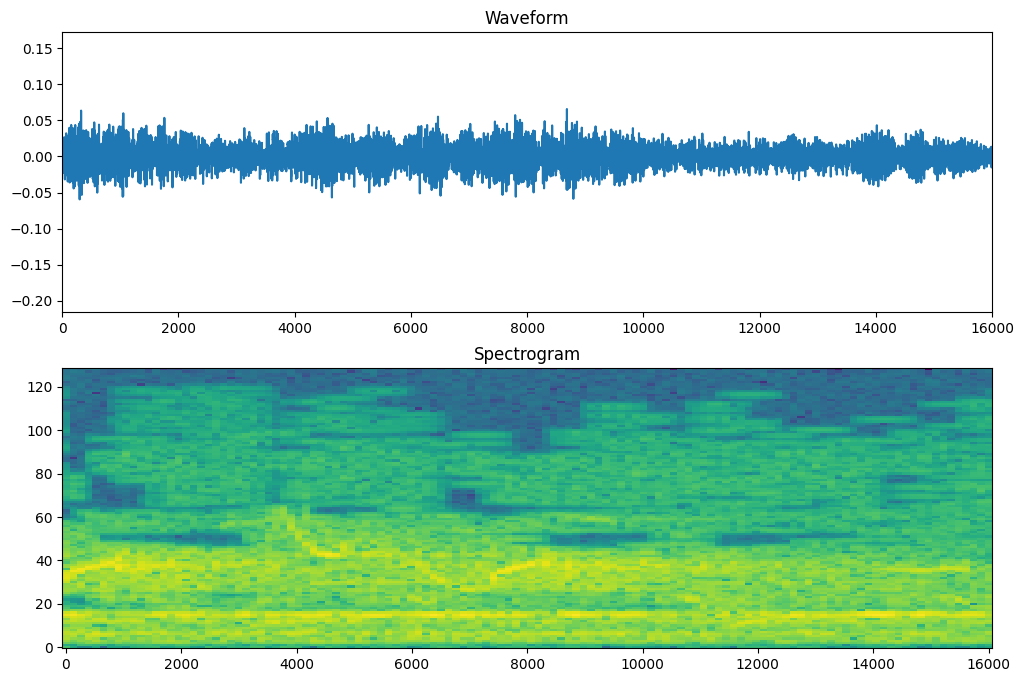

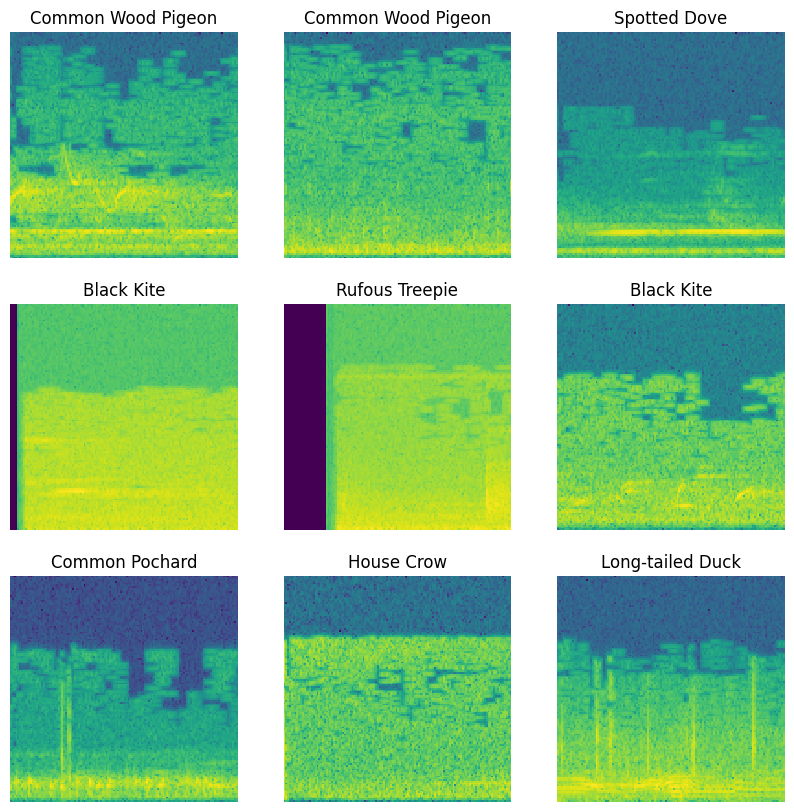

In [22]:
%run extractAudio.ipynb

In [23]:
RESIZING = 128 # 32 standard 

In [24]:
from tensorflow import keras
from keras import layers
from keras import models

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential(
    [
        layers.Input(shape=input_shape),

        # Downsample the input.
        layers.Resizing(RESIZING, RESIZING),
        layers.Normalization(), 

        # Convolutional layer 1
        layers.Conv2D(RESIZING, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Normalize.
        norm_layer,
        
        # Convolutional layer 2
        layers.Conv2D(RESIZING, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Convolutional layer 3
        layers.Conv2D(RESIZING, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),


        layers.Flatten(),
        layers.Dense(RESIZING, activation="relu"),
        layers.Dropout(0.5),
        # Use softmax activation for multi-class classification
        layers.Dense(num_labels, activation='softmax')
    ]
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_2 (Resizing)       (None, 128, 128, 1)       0         
                                                                 
 normalization_3 (Normaliza  (None, 128, 128, 1)       3         
 tion)                                                           
                                                                 
 conv2d_6 (Conv2D)           (None, 126, 126, 128)     1280      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 63, 63, 128)       0         
 g2D)                                                            
                                                                 
 normalization_2 (Normaliza  (None, 63, 63, 128)       3         
 tion)                                                           
                                                      

In [25]:
model.compile(
    optimizer           = tf.keras.optimizers.Adam(),
    loss                = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics             = ["accuracy"],
)

In [26]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data     = val_ds,
    epochs              = EPOCHS,
    callbacks           = tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10


C:\Users\romai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


82/82 [==============================] - 217s 3s/step - loss: 3.3753 - accuracy: 0.0855 - val_loss: 3.0081 - val_accuracy: 0.1440
Epoch 2/10
82/82 [==============================] - 185s 2s/step - loss: 3.0837 - accuracy: 0.1329 - val_loss: 2.8696 - val_accuracy: 0.1815
Epoch 3/10
82/82 [==============================] - 167s 2s/step - loss: 2.9124 - accuracy: 0.1802 - val_loss: 2.7884 - val_accuracy: 0.2238
Epoch 4/10
82/82 [==============================] - 163s 2s/step - loss: 2.7926 - accuracy: 0.2140 - val_loss: 2.6791 - val_accuracy: 0.2613
Epoch 5/10
82/82 [==============================] - 171s 2s/step - loss: 2.6639 - accuracy: 0.2538 - val_loss: 2.6219 - val_accuracy: 0.2848
Epoch 6/10
82/82 [==============================] - 182s 2s/step - loss: 2.5799 - accuracy: 0.2795 - val_loss: 2.5466 - val_accuracy: 0.2926
Epoch 7/10
82/82 [==============================] - 191s 2s/step - loss: 2.4806 - accuracy: 0.2997 - val_loss: 2.4897 - val_accuracy: 0.3114
Epoch 8/10
82/82 [======

In [32]:
model.save('m3.keras')

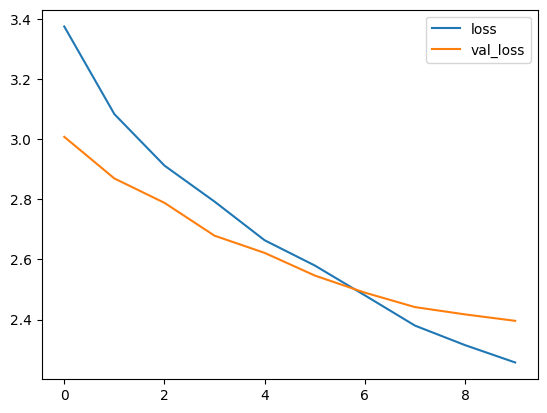

In [27]:
metrics = history.history
plt.plot(history.epoch, metrics["loss"], metrics["val_loss"])
plt.legend(["loss", "val_loss"])
plt.show()

In [28]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [29]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f"Test set accuracy: {test_acc:.0%}")

22/22 [==============================] - 7s 303ms/step
Test set accuracy: 34%


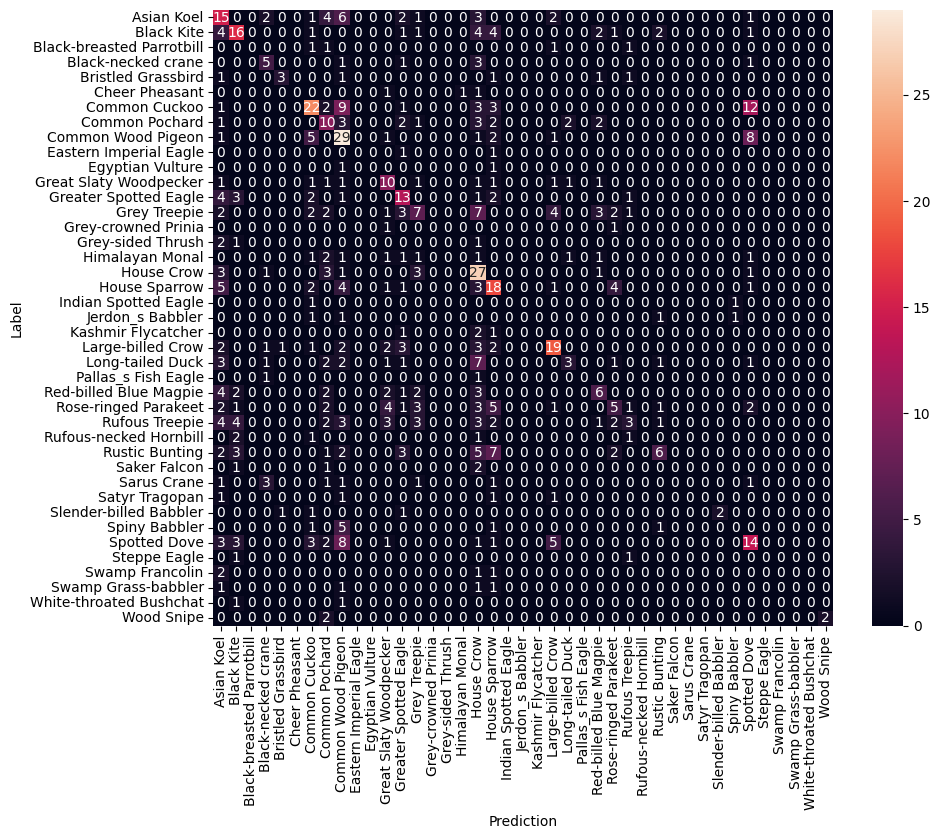

In [30]:
import seaborn as sns

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(
    confusion_mtx, xticklabels=birds, yticklabels=birds, annot=True, fmt="g"
)
plt.xlabel("Prediction")
plt.ylabel("Label")
plt.show()

In [ ]:
EXEMPLE_PATH = r'Data\test\Asian Koel\XC161198 1.wav'

Input = tf.io.read_file(str(EXEMPLE_PATH))

x, sample_rate = tf.audio.decode_wav(Input, desired_channels=1, desired_samples=16000,) 
audio, labels = squeeze(x, 'Asian Koel') 
  
waveform = audio 
display.display(display.Audio(waveform, rate=16000)) 
  
x = get_spectrogram(audio) 
x = tf.expand_dims(x, axis=0) 
  
prediction = model(x) 
plt.bar(birds, tf.nn.softmax(prediction[0])) 
plt.title('Prediction : '+birds[np.argmax(prediction, axis=1).item()]) 
plt.show()
